# Compare Models

Compare the heursitic model that was previously used and the logistic model that is 
currently used. 

In [1]:
%matplotlib inline
import numpy as np
from vessel_scoring import data
from vessel_scoring.evaluate_model import train_model, compare_auc, compare_metrics
from IPython.core.display import display, HTML, Markdown
from sklearn import metrics

In [2]:
# Load training and test data

_, train_lline,  _, test_lline = data.load_dataset_by_vessel(
        'datasets/kristina_longliner.measures.npz')
_, train_trawl,  _, test_trawl = data.load_dataset_by_vessel(
        'datasets/kristina_trawl.measures.npz')
_, train_pseine, _, test_pseine = data.load_dataset_by_vessel(
        'datasets/kristina_ps.measures.npz')

train = np.concatenate([train_trawl, train_lline, train_pseine])

In [3]:
# Prepare the models

from vessel_scoring.legacy_heuristic_model import LegacyHeuristicModel
from vessel_scoring.logistic_model import LogisticModel

uniform_training_data = {'longliner': train, 
                         'trawler': train, 
                         'purse seiner': train}

test_data = {'longliner': test_lline, 
             'trawler': test_trawl, 
             'purse seiner': test_pseine}

untrained_models = [
    ("Legacy (12 Hour)", LegacyHeuristicModel(window=43200), 
         uniform_training_data),
    ('Logistic (MW)', LogisticModel(windows=[1800, 3600, 10800, 21600, 43200, 86400],
                                    order=6), 
         uniform_training_data),
]

## Discrete Comparisons

The models output a numbers between 0 and 1 that correspond to how 
confident they are that there is fishing occuring. For
this first set of comparisons we treat predictions `>0.5`
as fishing and those `<=0.5` as nonfishing. This allows us to use
*precision*, *recall*, *f1-score* and *accuracy* as metrics.

In [4]:
import imp, vessel_scoring.evaluate_model; imp.reload(vessel_scoring.evaluate_model)
from vessel_scoring.evaluate_model import (train_model, compare_auc, compare_pr,
                                           compare_metrics, compare_metrics_table)

for vessel_class in ["longliner", "trawler", "purse seiner"]:
    display(HTML("<h3>Comparison for {0}</h3>".format(vessel_class)))
    models = []
    for name, mdl, train_data in untrained_models:
        models.append((name, train_model(mdl, train_data[vessel_class])))
    display(Markdown(compare_metrics_table(models, test_data[vessel_class])))

|                    |     Precision      |       Recall       |      F1-score      |
|--------------------|--------------------|--------------------|--------------------|
|  Legacy (12 Hour)  |       0.936        |       0.884        |       0.909        |
|   Logistic (MW)    |       0.980        |       0.763        |       0.858        |


|                    |     Precision      |       Recall       |      F1-score      |
|--------------------|--------------------|--------------------|--------------------|
|  Legacy (12 Hour)  |       0.736        |       0.985        |       0.843        |
|   Logistic (MW)    |       0.897        |       0.955        |       0.925        |


|                    |     Precision      |       Recall       |      F1-score      |
|--------------------|--------------------|--------------------|--------------------|
|  Legacy (12 Hour)  |       0.046        |       0.984        |       0.087        |
|   Logistic (MW)    |       0.103        |       0.919        |       0.185        |


## Precision - Recall Comparisons

One way to compare the models without picking a specific threshold is
to plot the precision versus recall of each model. Note that this (and the
following ROC plot) make it clear that the Logistic model performs better 
overall than the heursitic model, even for longliners, despite the better 
*f1* score of the heursitic model in the longliner case.

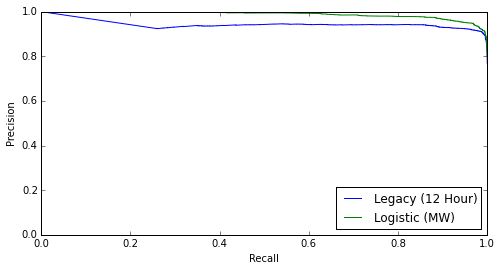

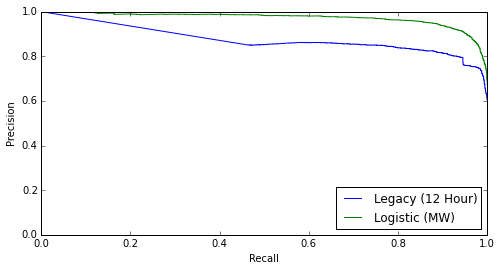

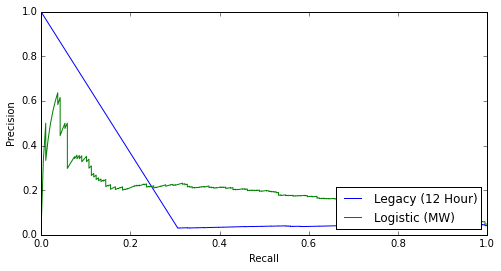

In [5]:
for vessel_class in ["longliner", "trawler", "purse seiner"]:
    display(HTML("<h3>Comparison for {0}</h3>".format(vessel_class)))
    models = []
    for name, mdl, train_data in untrained_models:
        models.append((name, train_model(mdl, train_data[vessel_class])))
    compare_pr(models, test_data[vessel_class])

## ROC Comparisons

Another approach to compare continuous output is the Receiver Operator Characteristic curve.
This curve plots *true positive rate* versus *false positive rate* and is useful for evaluating
what is possible with different threshold values.  The Area Under the Curve (AUC) is used as 
a metric in this case, with a larger AUC being better.

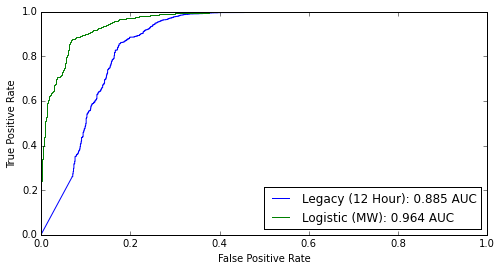

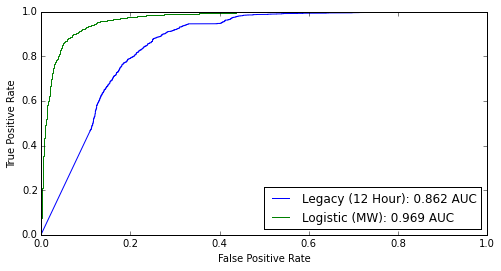

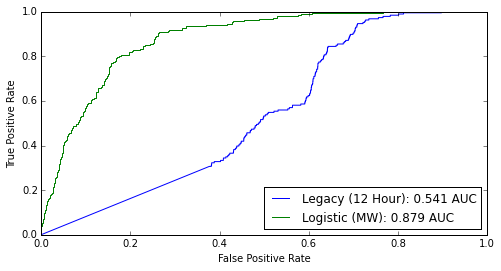

In [6]:
for vessel_class in ["longliner", "trawler", "purse seiner"]:
    display(HTML("<h3>Comparison for {0}</h3>".format(vessel_class)))
    models = []
    for name, mdl, train_data in untrained_models:
        models.append((name, train_model(mdl, train_data[vessel_class])))
    compare_auc(models, test_data[vessel_class])